## Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import squidpy as sq
from popsvg import preprocess_slices, spatial_lag_regression_cpu, TwoStageExpectationMaximizer

## Load data
This toy dataset contains a total of 2000 spots from 5 subjects, and 1000 genes.

In [2]:
combined_adata = sc.read_h5ad("data/tutorial_data.h5ad")
adatas= [combined_adata[combined_adata.obs["subject"] == subject].copy() for subject in combined_adata.obs["subject"].unique()]
adatas

[AnnData object with n_obs × n_vars = 400 × 1000
     obs: 'subject'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 400 × 1000
     obs: 'subject'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 400 × 1000
     obs: 'subject'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 400 × 1000
     obs: 'subject'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 400 × 1000
     obs: 'subject'
     obsm: 'spatial']

## Preprocess data
The function `preprocess_slices()` will also computes spatial neighborhood graphs. The argument `coord_type` is specified as `square` because spots are aranged on squre grids.

In [3]:
preprocess_slices(adatas, coord_type="square")

Checking slices:   0%|          | 0/5 [00:00<?, ?it/s]

Filtering features and normalizing in slices:   0%|          | 0/5 [00:00<?, ?it/s]

Preserved 1000 features after dropping mito and low-expressed features in all slices.
Features in all slices have been log-normalized.


Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


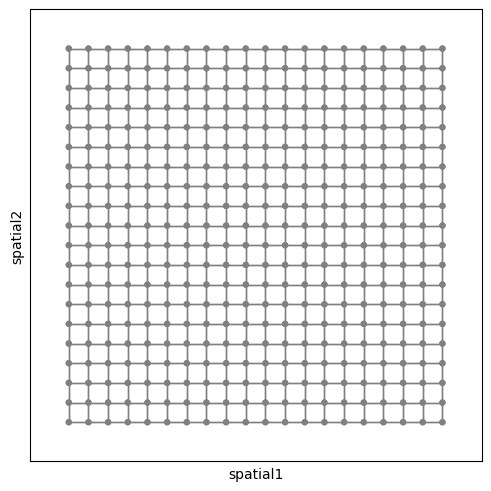

In [4]:
sq.pl.spatial_scatter(adatas[0], connectivity_key="spatial_connectivities", shape=None, na_color="grey", size=50)

## Fitting spatial lag regression on CPU

In [5]:
stats = spatial_lag_regression_cpu(adatas, n_workers=1)
X, kappa2 = stats["all_alpha"], stats["all_alpha_var"]

Fitting spatial lag regression on each slice:   0%|          | 0/5 [00:00<?, ?it/s]

Computing matrix power series:   0%|          | 0/9 [00:00<?, ?it/s]

Computing matrix power series:   0%|          | 0/9 [00:00<?, ?it/s]

Computing matrix power series:   0%|          | 0/9 [00:00<?, ?it/s]

Computing matrix power series:   0%|          | 0/9 [00:00<?, ?it/s]

Computing matrix power series:   0%|          | 0/9 [00:00<?, ?it/s]

## Fitting the hierarchical model
Some key arguments in the class `TwoStageExpectationMaximizer`:

- max_iter: Maximum number of iterations per EM stage
- n_workers: Number of parallel workers for gene-wise initialization
- rho_cutoff: Minimum acceptable population dependency for SVGs, converted to log-space threshold (alpha_cutoff)
- tol: Convergence tolerance for log-likelihood change between iterations

In [6]:
est = TwoStageExpectationMaximizer(max_iter=200, n_workers=1, rho_cutoff=0.25, tol=1e-3)
est.fit(X, kappa2)

Stage 1 iteration 001 - log LL change:   inf | current log LL: 1.202244
Stage 1 iteration 002 - log LL change: 0.033446 | current log LL: 1.235690
Stage 1 iteration 003 - log LL change: 0.017540 | current log LL: 1.253230
Stage 1 iteration 004 - log LL change: 0.011108 | current log LL: 1.264338
Stage 1 iteration 005 - log LL change: 0.007784 | current log LL: 1.272123
Stage 1 iteration 006 - log LL change: 0.005803 | current log LL: 1.277926
Stage 1 iteration 007 - log LL change: 0.004508 | current log LL: 1.282434
Stage 1 iteration 008 - log LL change: 0.003607 | current log LL: 1.286041
Stage 1 iteration 009 - log LL change: 0.002952 | current log LL: 1.288993
Stage 1 iteration 010 - log LL change: 0.002459 | current log LL: 1.291452
Stage 1 iteration 011 - log LL change: 0.002080 | current log LL: 1.293532
Stage 1 iteration 012 - log LL change: 0.001782 | current log LL: 1.295314
Stage 1 iteration 013 - log LL change: 0.001542 | current log LL: 1.296856
Stage 1 iteration 014 - log 

- `est.means_`: Mean dependency parameters for population-level SVGs
- `est.weights_`: Mixture weights in stage 1. The second column contains gene-level prevalence

In [7]:
print(est.means_.shape, est.weights_.shape)

(1000,) (1000, 2)


Posterior probabilities for population-level SVGs can be computed by:

In [8]:
print(est.predict_proba(X).shape)

(1000, 2)
